In [15]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

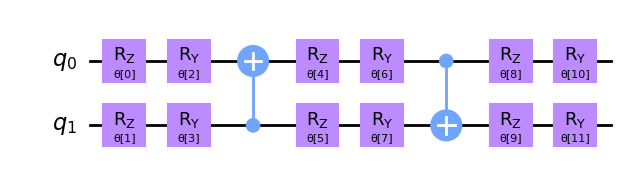

In [16]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = 12
def parametrized_gates(params):
    target = QuantumCircuit(2)
    target.rz(params[0], 0)
    target.rz(params[1], 1)
    target.ry(params[2], 0)
    target.ry(params[3], 1)
    target.cx(1, 0)
    target.rz(params[4], 0)
    target.rz(params[5], 1)
    target.ry(params[6], 0)
    target.ry(params[7], 1)
    target.cx(0,1)
    target.rz(params[8], 0)
    target.rz(params[9], 1)
    target.ry(params[10], 0)
    target.ry(params[11], 1)
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

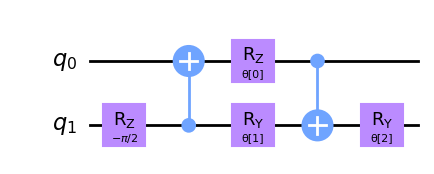

In [17]:
#Circuit to help with dimensionality reduction and combine two qubits into one
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

In [18]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

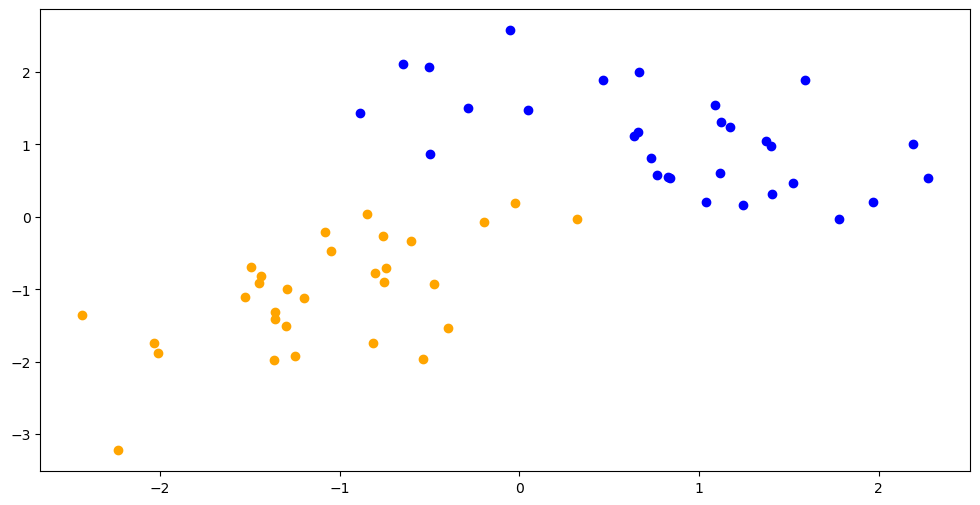

In [52]:
#Generates training data for classifier
#This is just to get a proof of concept. Eventually we can use the financial data
sample_size = 30
np.random.seed(1)
group0 = np.random.multivariate_normal([1,1], [[.75, -.5], [-.5, .75]], sample_size)
group1 = np.random.multivariate_normal([-1,-1], [[.75, .5], [.5, .75]], sample_size)

#Breaks data into training and testing groups
train_group0 = group0[0:sample_size//2,:]
test_group0 = group0[sample_size//2:sample_size,:]
train_group1 = group1[0:sample_size//2,:]
test_group1 = group1[sample_size//2:sample_size,:]
train_data = np.concatenate((train_group0, train_group1))
test_data = np.concatenate((test_group0, test_group1))
train_labels = np.concatenate((np.ones(sample_size//2), np.zeros(sample_size//2)-1))
test_labels = np.concatenate((np.ones(sample_size//2), np.zeros(sample_size//2)-1))

#Plots sample data
plt.scatter(group0[:,0], group0[:,1], color='blue')
plt.scatter(group1[:,0], group1[:,1], color='orange')
plt.show
data = np.concatenate((group0, group1))
labels = np.concatenate((np.ones(sample_size), np.zeros(sample_size)-1))

#Implemented the idea of a normalization constant since the feature map uses phase encoding and results in forced
#repeating patterns if not normalized
norm_const = 2*np.max(np.absolute(data))

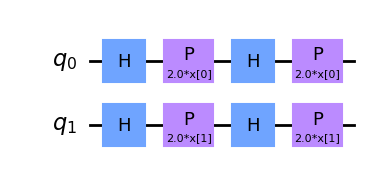

In [20]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(2)
feature_map.decompose().draw("mpl", style="clifford")

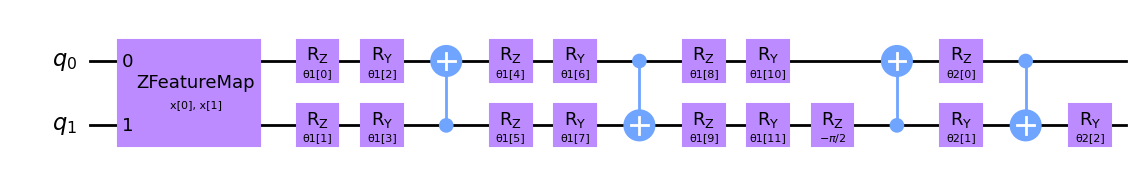

In [21]:
#Sets up full circuit with inputs and network
network = parametrized_gates(ParameterVector("θ1", length=num_params))
network.compose(pool_circuit(ParameterVector("θ2", length=3)), inplace=True)
ml_circuit = QuantumCircuit(2)
ml_circuit.compose(feature_map, inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [22]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [23]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I", 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [24]:
#Function used in classifier to plot objective function at each iteration
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [25]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph
)

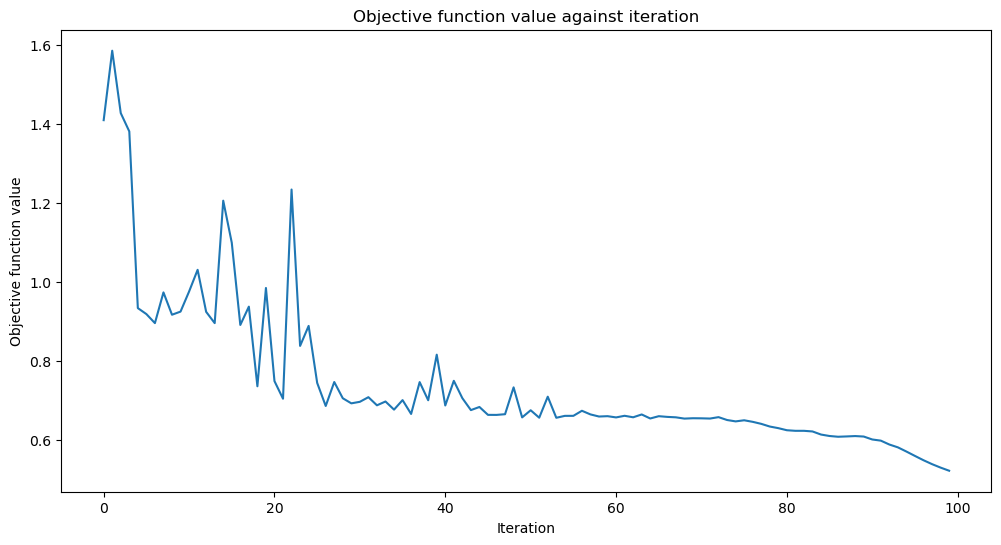

Accuracy from the test data : 93.33%


In [53]:
#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(np.divide(train_data,norm_const), train_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(np.divide(test_data,norm_const), test_labels), 2)}%")

In [54]:
#Visualizes decision boundary with sampled points overlayed
positive = np.array([[0],[0]])
negative = np.array([[0],[0]])
xAxis = np.linspace(-3,3,80)
yAxis = np.linspace(-3.5,3.5,80)
for i in xAxis:
    for j in yAxis:
        if classifier.predict([i/norm_const,j/norm_const]) == 1:
            positive = np.append(positive, [[i],[j]], axis=1)
        else:
            negative = np.append(negative, [[i],[j]], axis=1)
positive = positive[:,1:np.max(positive.shape)]
negative = negative[:,1:np.max(negative.shape)]

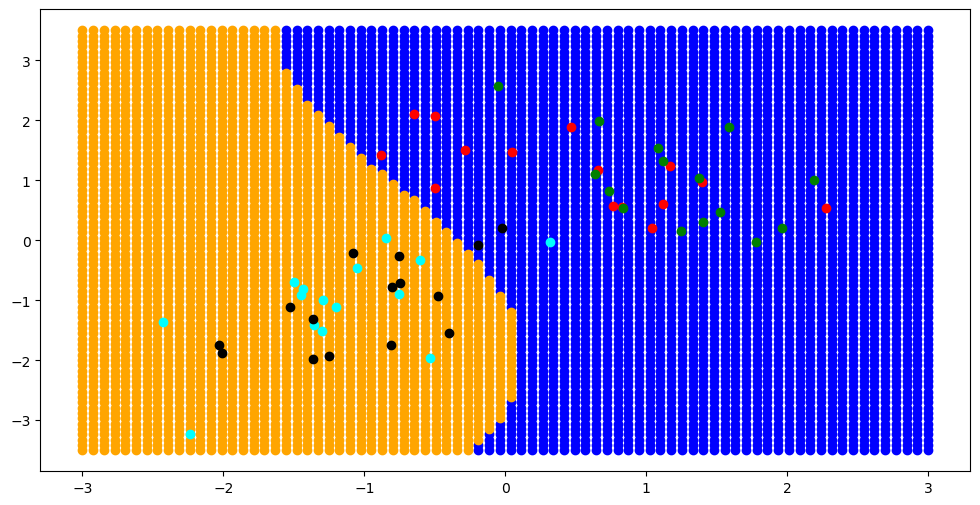

In [60]:
#Plots decision boundary and test/train data from each group
plt.scatter(positive[0,:], positive[1,:], color='blue')
plt.scatter(negative[0,:], negative[1,:], color='orange')
plt.scatter(train_group0[:,0], train_group0[:,1], color='red')
plt.scatter(train_group1[:,0], train_group1[:,1], color='cyan')
plt.scatter(test_group0[:,0], test_group0[:,1], color='green')
plt.scatter(test_group1[:,0], test_group1[:,1], color='black')